In [5]:
import torch
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [32]:
class Value: 
    def __init__(self, data, _children=(), _op='', label = ''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        # why set? do we lose any info here?
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self,other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out
    
    def __radd__(self, other):
        return self + other
    
    def __neg__(self):
        return -1 * self

    def __sub__(self, other):
        return self + (-other)
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data*other.data, (self,other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self*other
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)) #otherwise, the derivative will be different
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * self.data**(other-1) * out.grad
        out._backward = _backward
        return out

    def __truediv__(self, other): # self/other
        return self * other ** -1
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) -1)/(math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += (1-t**2)*out.grad 
        out._backward=_backward
        return out
    
    def exp(self):
        x=self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out
    
    # imp
    def backward(self):
        topo = []
        visited=set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad=1.0
        for node in reversed(topo):
            node._backward()


In [35]:
from graphviz import Digraph

def trace(root):
    # build a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    
    build(root)
    return nodes, edges

# this follows DOT syntax
def draw_dot(root): 
    # direction: left -> right
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label = f"{n.label} | data {n.data} | grad {n.grad}", shape='record')
        if n._op:
            dot.node(name = uid+n._op, label = n._op)
            dot.edge(uid+n._op, uid)
    for n1,n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [ ]:
class Neuron:
    def __init__(self, nin):
        self.w = torch.randn(nin, requires_grad=True)
        self.b = torch.randn(1, requires_grad=True)

    def __call__(self, x):
        zip(self)


x = [2.0, 3.0]
n = Neuron(2)
n(x)

0.0

In [46]:
import random
class Neuron: 
    def __init__(self, nin):
        self.w=[Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b=Value(random.uniform(-1,1))

    def __call__(self, x):
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]    
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for l in self.layers:
            x = l(x)
        return x
    
    def parameters(self):
        return [p for l in self.layers for p in l.parameters()]


x = [2.0, 3.0, 1.0]
# n = Neuron(2)
# n = Layer(3,2)
n = MLP(3, [4,4,1])
n(x)

Value(data=0.593551027671384)

In [47]:
x = [[2,3,-1.3333333], [3,-1.333333,0.5],[0.5,1.3333333,1], [1,1.3333333,-1]]
Y = [1,-10,-1,1]
y = [n(x) for x in x]
y

[Value(data=0.7139814423320249),
 Value(data=-0.29251931473553505),
 Value(data=0.4937258664693258),
 Value(data=0.7080242187482855)]

In [48]:
loss = sum((ypred-ytrue)**2 for ytrue, ypred in zip(Y, y))

In [49]:
loss

Value(data=96.63345469111019)

In [50]:
for p in n.parameters():
    p.grad=0
loss.backward()

In [55]:
n.layers[0].neurons[0].w[0].grad

2.200213145982207

In [56]:
n.layers[0].neurons[0].w[0].data

0.17365546272468313

In [57]:
for p in n.parameters():
    p.data -= 0.001 * p.grad

In [59]:
n.layers[0].neurons[0].w[0].data

0.17145524957870092

In [60]:
y = [n(x) for x in x]
loss = sum((ypred-ytrue)**2 for ytrue, ypred in zip(Y, y))

In [61]:
loss

Value(data=95.14613931011512)

In [62]:
# gradient descent
for k in range(20):
    # forward pass
    ypred = [n(x) for x in x]
    loss = sum((yout - ygt)**2 for yout, ygt in zip(ypred, Y))

    # backward pass 
    for p in n.parameters():
        p.grad = 0

    loss.backward()

    # update params
    for p in n.parameters():
        p.data -= 0.01 * p.grad

    print(k, loss.data)


0 95.14613931011512
1 87.15627346282822
2 85.1713538867351
3 84.11810127181737
4 83.45000814229222
5 83.00516843535563
6 82.69794105130816
7 82.47461003658454
8 82.30382768112747
9 82.16792898414138
10 82.05663790282847
11 81.9635911036046
12 81.88458273743313
13 81.81667455254667
14 81.75772343820763
15 81.70611460434368
16 81.66060105713169
17 81.6202013388732
18 81.58413117166675
19 81.5517559522246


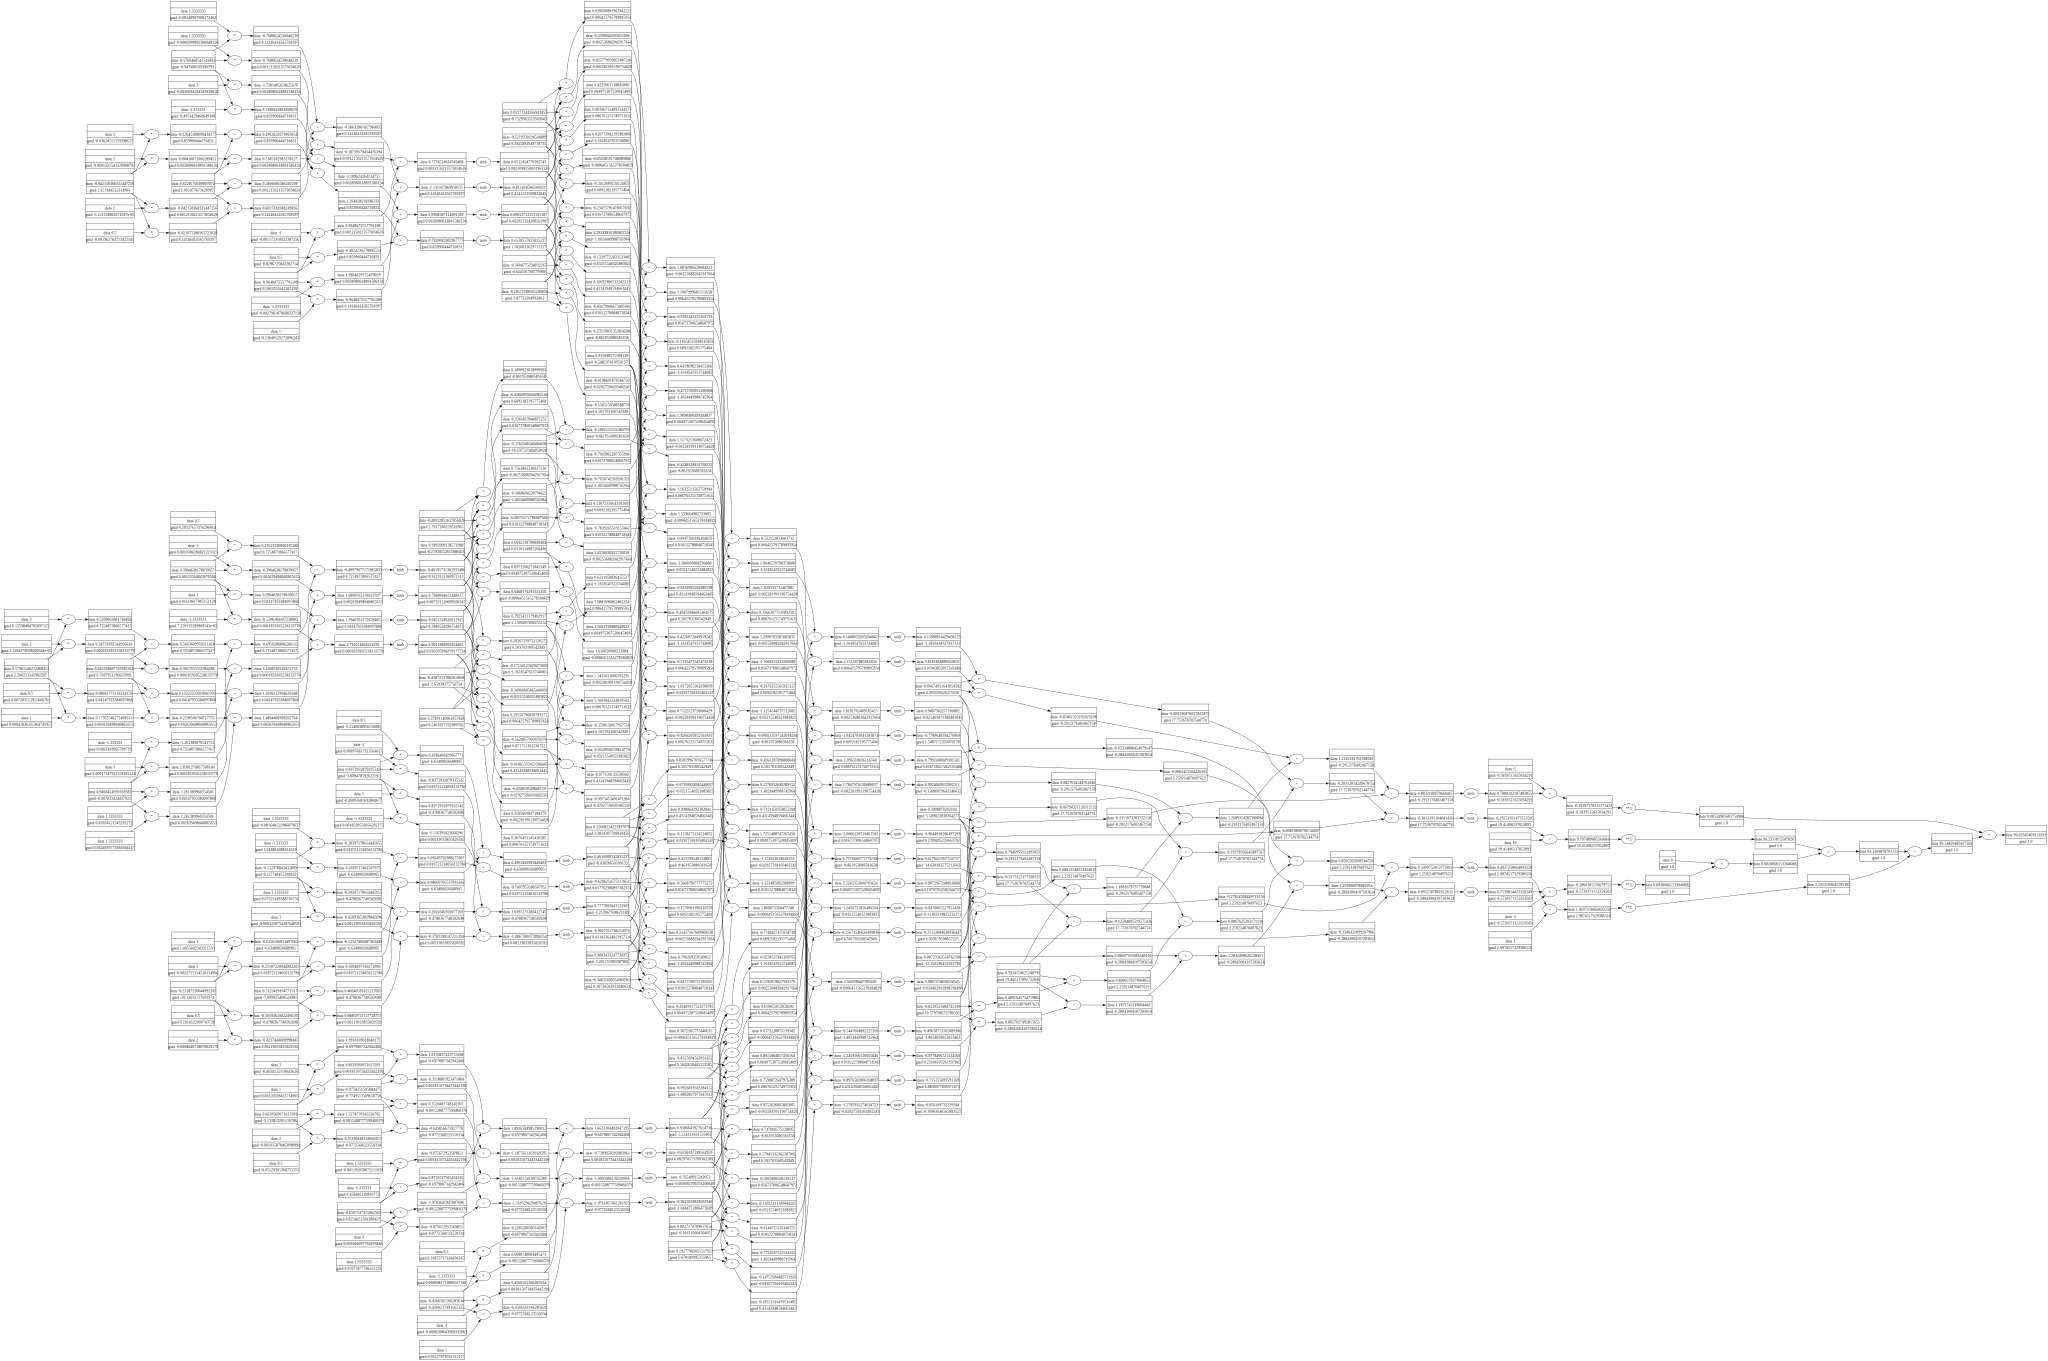

In [51]:
draw_dot(loss)

In [ ]:
class Neuron:
    def __init__(self, nin):
        self.w = torch.randn(nin, requires_grad=True)
        self.b = torch.randn(1, requires_grad=True)

    def __call__(self, x):
        zip(self)


x = [2.0, 3.0]
n = Neuron(2)
n(x)

0.0